# Access to ALeRCE mutistream data (staging)
Author: Javier Arredondo, Last updated: 2021/10/28

__Notebook under development__

### Everything you need to know about MongoDB (very brief) 

> MongoDB is an open-source document-oriented database. ... MongoDB is not based on the table-like relational database structure but provides an altogether different mechanism for storage and retrieval of data, that's why known as NoSQL database. Here, the term 'NoSQL' means 'non-relational ([Geeks for Geeks](https://www.geeksforgeeks.org/how-mongodb-works/), 2020)

There are no tables or relationships in MongoDB. This database works with "documents", which are stored in [BSON](https://docs.mongodb.com/manual/core/document/#std-label-bson-document-format) format (the name BSON is based on the term JSON and stands for Binary JSON).

Documents are stored in a set called collections. Collections are similar to tables in relational databases and can have some properties such as indexes, statistics, among others.

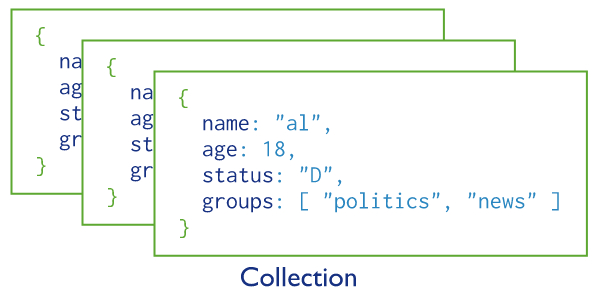

The documents are not structured, that is, they do not need to have the same fields in the BSON. For example:

```json
{
    "_id" : ObjectId("6179942efa070061aed8fe6b"),
    "name" : "James",
    "age" : 43
}
{
    "_id" : ObjectId("6179942efa070061aed8fe77"),
    "name" : "Frederick",
    "age" : 21,
    "has_pets": true
}
{
    "_id" : ObjectId("6179942efa070061aed8fe77"),
    "name" : "Alphonse",
    "has_pets": false
}
```

## Proposal of this notebook

This notebook shows you how to connect to MongoDB database, and how to access to data. Also has some examples of typical astro-queries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We use an own library to connect to MongoDB. [db-plugins](https://github.com/alercebroker/db-plugins) is an ORM style library created to interact with different databases. In this notebook we use this for connect to MongoDB and read data. For install it:

```bash
pip install git+https://github.com/alercebroker/db-plugins.git
```

In [2]:
from db_plugins.db.generic import new_DBConnection
from db_plugins.db.mongo.connection import MongoConnection, MongoDatabaseCreator
from db_plugins.db.mongo.models import Object, Detection, NonDetection

Public credentials of staging MongoDB

In [3]:
DB_CONFIG = {
    "HOST": "50.17.119.56:27017",
    "USER": "reader",
    "PASSWORD": "N3?264[<sRq2Pkb;",
    "DATABASE": "staging",
    "PORT": 27017
}

In [4]:
driver = new_DBConnection(MongoDatabaseCreator)
driver.connect(DB_CONFIG)

### Some stats of `staging` database

In [5]:
driver.client["staging"].command("dbstats")

{'db': 'staging',
 'collections': 3,
 'views': 0,
 'objects': 44981,
 'avgObjSize': 592.5837575865365,
 'dataSize': 26655010.0,
 'storageSize': 13504512.0,
 'indexes': 4,
 'indexSize': 925696.0,
 'totalSize': 14430208.0,
 'scaleFactor': 1.0,
 'fsUsedSize': 3406045184.0,
 'fsTotalSize': 52576092160.0,
 'ok': 1.0}

What collections exist in database?

In [6]:
collections = driver.client["staging"].list_collection_names()

Get some stats by collection. With this we can analyze the size of indexes or total size by collection.

In [7]:
for col in collections:
    stats = driver.client["staging"].command("collstats", col)
    del stats["wiredTiger"]
    del stats["indexDetails"]
    display(stats)

{'ns': 'staging.non_detection',
 'size': 2914912,
 'count': 26026,
 'avgObjSize': 112,
 'storageSize': 1495040,
 'freeStorageSize': 737280,
 'capped': False,
 'nindexes': 1,
 'indexBuilds': [],
 'totalIndexSize': 487424,
 'totalSize': 1982464,
 'indexSizes': {'_id_': 487424},
 'scaleFactor': 1,
 'ok': 1.0}

{'ns': 'staging.detection',
 'size': 23469143,
 'count': 17802,
 'avgObjSize': 1318,
 'storageSize': 11747328,
 'freeStorageSize': 3596288,
 'capped': False,
 'nindexes': 1,
 'indexBuilds': [],
 'totalIndexSize': 339968,
 'totalSize': 12087296,
 'indexSizes': {'_id_': 339968},
 'scaleFactor': 1,
 'ok': 1.0}

{'ns': 'staging.object',
 'size': 270955,
 'count': 1153,
 'avgObjSize': 235,
 'storageSize': 262144,
 'freeStorageSize': 126976,
 'capped': False,
 'nindexes': 2,
 'indexBuilds': [],
 'totalIndexSize': 98304,
 'totalSize': 360448,
 'indexSizes': {'_id_': 61440, 'loc_2dsphere': 36864},
 'scaleFactor': 1,
 'ok': 1.0}

### Get all objects

And analyze the query with db-plugins (pymongo) toolset.

In [8]:
objects_query = driver.query().find_all(Object, filter_by={}, paginate=False)

In [9]:
objects_query.explain()

{'queryPlanner': {'plannerVersion': 1,
  'namespace': 'staging.object',
  'indexFilterSet': False,
  'parsedQuery': {},
  'winningPlan': {'stage': 'COLLSCAN', 'direction': 'forward'},
  'rejectedPlans': []},
 'executionStats': {'executionSuccess': True,
  'nReturned': 1153,
  'executionTimeMillis': 0,
  'totalKeysExamined': 0,
  'totalDocsExamined': 1153,
  'executionStages': {'stage': 'COLLSCAN',
   'nReturned': 1153,
   'executionTimeMillisEstimate': 0,
   'works': 1155,
   'advanced': 1153,
   'needTime': 1,
   'needYield': 0,
   'saveState': 1,
   'restoreState': 1,
   'isEOF': 1,
   'direction': 'forward',
   'docsExamined': 1153},
  'allPlansExecution': []},
 'serverInfo': {'host': 'ip-15-0-7-46',
  'port': 27017,
  'version': '4.4.6',
  'gitVersion': '72e66213c2c3eab37d9358d5e78ad7f5c1d0d0d7'},
 'ok': 1.0}

In [10]:
objects = [o for o in objects_query]
objects = pd.DataFrame(objects)

In [11]:
objects

,_id,aid,meanra,meandec,sigmara,sigmadec,firstmjd,lastmjd,tid,oid,loc
0,1000010351740823300,1000010351740823300,0.002804,4.819088,0.000163,0.000046,59373.443935,59387.370000,ZTF,ZTF18accslat,"{'type': 'Point', 'coordinates': [-179.9971961..."
1,1001949491163914700,1001949491163914700,0.421280,1.415599,0.000066,0.000037,59480.290394,59502.352106,ZTF,ZTF18abncrdm,"{'type': 'Point', 'coordinates': [-179.5787197..."
2,1004914451311304200,1004914451311304200,1.046371,2.653516,0.000081,0.000055,59340.487500,59357.476609,ZTF,ZTF19aavkaio,"{'type': 'Point', 'coordinates': [-178.9536307..."
3,1004942131523749200,1004942131523749200,1.056174,4.473580,0.000000,0.000000,59340.480000,59340.480000,ZTF,ZTF18abrbbwt,"{'type': 'Point', 'coordinates': [-178.9438256..."
4,1005353011595452600,1005353011595452600,1.145027,5.092744,0.000000,0.000000,59228.123102,59228.123102,ZTF,ZTF18abcjztx,"{'type': 'Point', 'coordinates': [-178.8549733..."
...,...,...,...,...,...,...,...,...,...,...,...
1148,1214617151023013600,1214617151023013600,27.758574,0.212823,0.000071,0.000076,59300.528125,59307.510903,ZTF,ZTF18abnygys,"{'type': 'Point', 'coordinates': [-152.2414258..."
1149,1221729461732730100,1221729461732730100,21.734230,4.774794,0.000247,0.000033,59446.364560,59476.254803,ZTF,ZTF19aaprrzz,"{'type': 'Point', 'coordinates': [-158.2657700..."
1150,1222838961453700000,1222838961453700000,21.915554,2.965084,0.000032,0.000043,59467.219468,59489.244803,ZTF,ZTF18abccscm,"{'type': 'Point', 'coordinates': [-158.0844459..."
1151,1224051641524919300,1224051641524919300,28.918292,4.489873,0.000064,0.000054,59164.179838,59194.134803,ZTF,ZTF18abchtiu,"{'type': 'Point', 'coordinates': [-151.0817081..."


### Getting detections of an object

An error that we have for now is the generation of `aid` for the objects. For example the object with `aid=1004914451311304200` (that corresponds to `ZTF19aavkaio`) only has 282 detections. But, If you look for the object `oid=ZTF19aavkaio` in the database, you will notice that there are more associated detections. 

In [12]:
detections_query = driver.query().find_all(Detection, filter_by={"aid": 1004914451311304200}, paginate=False)
detections = [d for d in detections_query]
detections = pd.DataFrame(detections)
display(detections)

,_id,aid,tid,oid,candid,mjd,fid,ra,dec,rb,...,sigmara,sigmadec,extra_fields,has_stamp,parent_candid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious
0,6179942efa070061aed8ff13,1004914451311304200,ZTF,ZTF19aavkaio,1608470100015010000,59362.470104,2,12.310226,31.217841,0.955714,...,0.085,0.085,"{'diffmaglim': 19.47269058227539, 'pdiffimfile...",True,NaN,19.078269,0.111056,0.122113,True,False
1,6179942efa070061aed905d5,1004914451311304200,ZTF,ZTF19aavkaio,1586487500015010000,59340.487500,2,12.310192,31.217848,0.931429,...,NaN,NaN,"{'diffmaglim': 19.28969955444336, 'pdiffimfile...",False,1.608470e+18,19.105889,0.146005,0.155016,True,False
2,6179942efa070061aed905d6,1004914451311304200,ZTF,ZTF19aavkaio,1586492210015010001,59340.492211,2,12.310245,31.217888,0.891429,...,NaN,NaN,"{'diffmaglim': 18.917800903320312, 'pdiffimfil...",False,1.608470e+18,19.107951,0.213135,0.219430,True,False
3,6179942efa070061aed905d7,1004914451311304200,ZTF,ZTF19aavkaio,1586494560015010006,59340.494560,2,12.310204,31.217886,0.742857,...,NaN,NaN,"{'diffmaglim': 18.754600524902344, 'pdiffimfil...",False,1.608470e+18,19.343455,0.343513,0.349576,True,False
4,6179942efa070061aed905d8,1004914451311304200,ZTF,ZTF19aavkaio,1587487690015010002,59341.487697,2,12.310336,31.217804,0.658571,...,NaN,NaN,"{'diffmaglim': 18.827800750732422, 'pdiffimfil...",False,1.608470e+18,19.243640,0.274852,0.281140,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,61799912781fa3426382324d,1004914451311304200,ZTF,ZTF19aavkaio,1602486481315010026,59356.486481,2,12.310216,31.217843,0.834286,...,NaN,NaN,"{'diffmaglim': 18.908899307250977, 'pdiffimfil...",False,1.603477e+18,19.242336,0.259184,0.261861,True,False
278,61799912781fa3426382324e,1004914451311304200,ZTF,ZTF19aavkaio,1603470930015010000,59357.470937,2,12.310244,31.217825,0.952857,...,NaN,NaN,"{'diffmaglim': 19.72920036315918, 'pdiffimfile...",False,1.603477e+18,19.157549,0.111547,0.124202,True,False
279,61799912781fa3426382324f,1004914451311304200,ZTF,ZTF19aavkaio,1603472340015010000,59357.472349,2,12.310265,31.217890,0.964286,...,NaN,NaN,"{'diffmaglim': 19.776100158691406, 'pdiffimfil...",False,1.603477e+18,19.103402,0.101219,0.113779,True,False
280,61799912781fa34263823250,1004914451311304200,ZTF,ZTF19aavkaio,1603473770015010001,59357.473773,2,12.310277,31.217766,0.932857,...,NaN,NaN,"{'diffmaglim': 19.59510040283203, 'pdiffimfile...",False,1.603477e+18,19.109038,0.140526,0.149920,True,False


In [13]:
detections_query = driver.query().find_all(Detection, filter_by={"oid": "ZTF19aavkaio"}, paginate=False)
detections = [d for d in detections_query]
detections = pd.DataFrame(detections)
display(detections)

,_id,aid,tid,oid,candid,mjd,fid,ra,dec,rb,...,sigmara,sigmadec,extra_fields,has_stamp,parent_candid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious
0,6179942efa070061aed8ff13,1004914451311304200,ZTF,ZTF19aavkaio,1608470100015010000,59362.470104,2,12.310226,31.217841,0.955714,...,0.085,0.085,"{'diffmaglim': 19.47269058227539, 'pdiffimfile...",True,NaN,19.078269,0.111056,0.122113,True,False
1,6179942efa070061aed905d5,1004914451311304200,ZTF,ZTF19aavkaio,1586487500015010000,59340.487500,2,12.310192,31.217848,0.931429,...,NaN,NaN,"{'diffmaglim': 19.28969955444336, 'pdiffimfile...",False,1.608470e+18,19.105889,0.146005,0.155016,True,False
2,6179942efa070061aed905d6,1004914451311304200,ZTF,ZTF19aavkaio,1586492210015010001,59340.492211,2,12.310245,31.217888,0.891429,...,NaN,NaN,"{'diffmaglim': 18.917800903320312, 'pdiffimfil...",False,1.608470e+18,19.107951,0.213135,0.219430,True,False
3,6179942efa070061aed905d7,1004914451311304200,ZTF,ZTF19aavkaio,1586494560015010006,59340.494560,2,12.310204,31.217886,0.742857,...,NaN,NaN,"{'diffmaglim': 18.754600524902344, 'pdiffimfil...",False,1.608470e+18,19.343455,0.343513,0.349576,True,False
4,6179942efa070061aed905d8,1004914451311304200,ZTF,ZTF19aavkaio,1587487690015010002,59341.487697,2,12.310336,31.217804,0.658571,...,NaN,NaN,"{'diffmaglim': 18.827800750732422, 'pdiffimfil...",False,1.608470e+18,19.243640,0.274852,0.281140,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,6179991e781fa34263823dbc,1004914461311304100,ZTF,ZTF19aavkaio,1617466631315010003,59371.466632,2,12.310222,31.217887,0.957143,...,NaN,NaN,"{'diffmaglim': 20.403099060058594, 'pdiffimfil...",False,1.631392e+18,19.044223,0.083041,0.088680,True,False
416,6179991e781fa34263823dbd,1004914461311304100,ZTF,ZTF19aavkaio,1619462041315010001,59373.462049,2,12.310255,31.217865,0.955714,...,NaN,NaN,"{'diffmaglim': 20.29840087890625, 'pdiffimfile...",False,1.631392e+18,19.122583,0.098120,0.103664,True,False
417,6179991e781fa34263823dbe,1004914461311304100,ZTF,ZTF19aavkaio,1619465981315010002,59373.465984,2,12.310256,31.217848,0.972857,...,NaN,NaN,"{'diffmaglim': 20.225299835205078, 'pdiffimfil...",False,1.631392e+18,19.121931,0.117215,0.121888,True,False
418,6179991e781fa34263823dbf,1004914461311304100,ZTF,ZTF19aavkaio,1619467951315010002,59373.467951,2,12.310249,31.217847,0.945714,...,NaN,NaN,"{'diffmaglim': 20.199199676513672, 'pdiffimfil...",False,1.631392e+18,19.026846,0.118133,0.122038,True,False


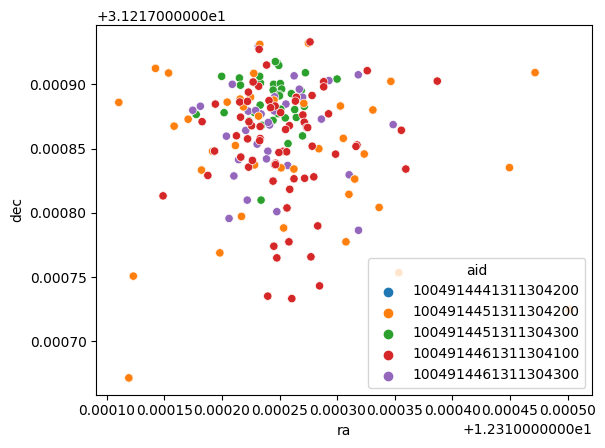

In [14]:
sns.scatterplot(data=detections, x="ra", y="dec", hue="aid", palette="tab10")
plt.show()

### Detections with some conditions

If you want to do a query like:

```sql
SELECT *
FROM detection
WHERE rb > 0.7 OR fid = 1
```

In [15]:
detections_query = driver.query().find_all(Detection, 
                                           filter_by=
                                           {
                                               "$or": [
                                                   {"rb": { "$gt": 0.7 }}, 
                                                   {"fid": 1}
                                               ]
                                           },
                                           paginate=False)
detections = [d for d in detections_query]
detections = pd.DataFrame(detections)
display(detections)

,_id,aid,tid,oid,candid,mjd,fid,ra,dec,rb,...,sigmara,sigmadec,extra_fields,has_stamp,parent_candid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious
0,6179942efa070061aed8fe6b,1181230100190154800,ZTF,ZTF18abgwrem,1724150000015010000,59478.150000,1,273.125438,-19.031903,0.450000,...,0.065,0.065,"{'diffmaglim': 18.834243774414062, 'pdiffimfil...",True,NaN,15.010687,100.000000,0.010612,True,False
1,6179942efa070061aed8fe6c,1080756291810048100,ZTF,ZTF20aaehomd,1468301000015010000,59222.301007,1,121.984562,81.013389,0.901429,...,0.065,0.065,"{'diffmaglim': 20.465282440185547, 'pdiffimfil...",True,NaN,16.103039,100.000000,0.006815,True,False
2,6179942efa070061aed8fe6d,1175226121453059400,ZTF,ZTF18aabtvtv,1549412000015010000,59303.412002,1,268.108862,45.516502,0.852857,...,0.065,0.065,"{'diffmaglim': 19.334745407104492, 'pdiffimfil...",True,NaN,19.895413,0.299639,0.303863,True,False
3,6179942efa070061aed8fe6e,1162335131094354000,ZTF,ZTF18abmjvki,1732132000015010000,59486.132002,1,245.896392,9.731671,0.798571,...,0.065,0.065,"{'diffmaglim': 20.182649612426758, 'pdiffimfil...",True,NaN,14.606305,100.000000,0.010618,True,False
4,6179942efa070061aed8fe6f,1194010150044901400,ZTF,ZTF18abnjzql,1546503000015010000,59300.503009,1,295.042303,-4.817073,0.814286,...,0.065,0.065,"{'diffmaglim': 18.8303279876709, 'pdiffimfilen...",True,NaN,15.922076,0.009324,0.020069,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14988,61799934781fa3426382564f,1152302601382020100,ZTF,ZTF19aalcjmz,1682243110015010000,59436.243113,1,230.760896,38.338910,0.961429,...,NaN,NaN,"{'diffmaglim': 20.354799270629883, 'pdiffimfil...",False,1.685200e+18,18.967922,0.080946,0.086923,True,False
14989,61799934781fa34263825650,1152302601382020100,ZTF,ZTF19aalcjmz,1682264291315010000,59436.264294,1,230.760764,38.338912,0.938571,...,NaN,NaN,"{'diffmaglim': 20.206100463867188, 'pdiffimfil...",False,1.685200e+18,18.938617,0.102590,0.106616,True,False
14990,61799934781fa34263825651,1152302601382020100,ZTF,ZTF19aalcjmz,1685181871315010000,59439.181875,1,230.760822,38.338914,0.978571,...,NaN,NaN,"{'diffmaglim': 20.027700424194336, 'pdiffimfil...",False,1.685200e+18,18.909842,0.094253,0.098399,True,False
14991,61799934781fa34263825652,1152302601382020100,ZTF,ZTF19aalcjmz,1685187620015010000,59439.187627,1,230.760896,38.338943,0.975714,...,NaN,NaN,"{'diffmaglim': 19.987499237060547, 'pdiffimfil...",False,1.685200e+18,18.887360,0.095453,0.099881,True,False


```sql
SELECT *
FROM detection
WHERE rb > 0.7 AND fid = 1
```

In [16]:
detections_query = driver.query().find_all(Detection, 
                                           filter_by={
                                               "rb": { "$gt": 0.7 },
                                               "fid": 1
                                           },
                                           paginate=False)
detections = [d for d in detections_query]
detections = pd.DataFrame(detections)
display(detections)

,_id,aid,tid,oid,candid,mjd,fid,ra,dec,rb,...,sigmara,sigmadec,extra_fields,has_stamp,parent_candid,magpsf_corr,sigmapsf_corr,sigmapsf_corr_ext,corrected,dubious
0,6179942efa070061aed8fe6c,1080756291810048100,ZTF,ZTF20aaehomd,1468301000015010000,59222.301007,1,121.984562,81.013389,0.901429,...,0.065,0.065,"{'diffmaglim': 20.465282440185547, 'pdiffimfil...",True,NaN,16.103039,100.000000,0.006815,True,False
1,6179942efa070061aed8fe6d,1175226121453059400,ZTF,ZTF18aabtvtv,1549412000015010000,59303.412002,1,268.108862,45.516502,0.852857,...,0.065,0.065,"{'diffmaglim': 19.334745407104492, 'pdiffimfil...",True,NaN,19.895413,0.299639,0.303863,True,False
2,6179942efa070061aed8fe6e,1162335131094354000,ZTF,ZTF18abmjvki,1732132000015010000,59486.132002,1,245.896392,9.731671,0.798571,...,0.065,0.065,"{'diffmaglim': 20.182649612426758, 'pdiffimfil...",True,NaN,14.606305,100.000000,0.010618,True,False
3,6179942efa070061aed8fe6f,1194010150044901400,ZTF,ZTF18abnjzql,1546503000015010000,59300.503009,1,295.042303,-4.817073,0.814286,...,0.065,0.065,"{'diffmaglim': 18.8303279876709, 'pdiffimfilen...",True,NaN,15.922076,0.009324,0.020069,True,False
4,6179942efa070061aed8fe72,1092554411524241500,ZTF,ZTF18aaagzzc,1435494000015010000,59189.494005,1,141.476721,52.711545,0.915714,...,0.065,0.065,"{'diffmaglim': 19.980239868164062, 'pdiffimfil...",True,NaN,16.498885,100.000000,0.010816,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6960,61799934781fa3426382564d,1152302601382020100,ZTF,ZTF19aalcjmz,1680226510015010000,59434.226516,1,230.760917,38.338893,0.962857,...,NaN,NaN,"{'diffmaglim': 20.57819938659668, 'pdiffimfile...",False,1.685200e+18,18.863730,0.063020,0.069280,True,False
6961,61799934781fa3426382564f,1152302601382020100,ZTF,ZTF19aalcjmz,1682243110015010000,59436.243113,1,230.760896,38.338910,0.961429,...,NaN,NaN,"{'diffmaglim': 20.354799270629883, 'pdiffimfil...",False,1.685200e+18,18.967922,0.080946,0.086923,True,False
6962,61799934781fa34263825650,1152302601382020100,ZTF,ZTF19aalcjmz,1682264291315010000,59436.264294,1,230.760764,38.338912,0.938571,...,NaN,NaN,"{'diffmaglim': 20.206100463867188, 'pdiffimfil...",False,1.685200e+18,18.938617,0.102590,0.106616,True,False
6963,61799934781fa34263825651,1152302601382020100,ZTF,ZTF19aalcjmz,1685181871315010000,59439.181875,1,230.760822,38.338914,0.978571,...,NaN,NaN,"{'diffmaglim': 20.027700424194336, 'pdiffimfil...",False,1.685200e+18,18.909842,0.094253,0.098399,True,False


### Spatial query in objects collection

For do spatial queries, we use a conversion and projection of celestial coordinates to sphere. 

In [17]:
def wgs_scale(lat):
    # Get scaling to convert degrees to meters at a given geodetic latitude (declination)

    # Values from WGS 84
    a = 6378137.000000000000  # Semi-major axis of Earth
    b = 6356752.314140000000  # Semi-minor axis of Earth
    e = 0.081819190842600  # eccentricity
    angle = np.radians(1.0)

    # Compute radius of curvature along meridian (see https://en.wikipedia.org/wiki/Meridian_arc)
    rm = a * (1 - np.power(e, 2)) / np.power((1 - np.power(e, 2) * np.power(np.sin(np.radians(lat)), 2)), 1.5)

    # Compute length of arc at this latitude (meters/degree)
    arc = rm * angle
    return arc

def cone_search(ra, dec, radius, db):
    radius = radius/3600
    scaling = wgs_scale(dec)
    meter_radius = radius * scaling
    lon, lat = ra - 180., dec
    objects = db.client["staging"]["object"]
    cursor = objects.find({
        'loc': {
            '$nearSphere': {
                '$geometry': {
                    'type': 'Point',
                    'coordinates': [lon, lat]
                },
                '$maxDistance': meter_radius
            }
        }
    })
    return cursor

In [18]:
spatial =  [cs for cs in cone_search(0.421280, 1.415599, 1.5, driver)]
spatial = pd.DataFrame(spatial)
display(spatial)

,_id,aid,meanra,meandec,sigmara,sigmadec,firstmjd,lastmjd,tid,oid,loc
0,1001949491163914700,1001949491163914700,0.42128,1.415599,0.000066,0.000037,59480.290394,59502.352106,ZTF,ZTF18abncrdm,"{'type': 'Point', 'coordinates': [-179.5787197..."
